In [1]:
import numpy as np
from EqDataParser import load_earthquake_data
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import freqz
from keras.backend import image_data_format
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras import regularizers
from keras.layers import MaxPooling1D
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout
import keras
import sys

Using TensorFlow backend.


In [2]:
(x_train,y_train),(x_test,y_test) = load_earthquake_data('./All Stations Three Components',image_data_format(),[1.0])

Reading Data.
Percentage finished: 100 % 

Timestretching signals.
Percentage finishied: 100 % 

Filtering & channelizing.
Percentage finished: 100 % 



In [3]:
y_tr = keras.utils.to_categorical(y_train, 10)
y_te = keras.utils.to_categorical(y_test, 10)

In [4]:
batch_size=1
num_classes=10
epochs=1

In [5]:
input_shape = (None,3)
first_layer = Conv1D(filters=96,kernel_size=11,strides=2,padding='causal', \
                 activation='relu',use_bias=True,kernel_initializer='TruncatedNormal', \
                 bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01), \
                 bias_regularizer=regularizers.l2(0.01),input_shape=input_shape)
layer2 = Conv1D(filters=256,kernel_size=5,strides=2,padding='causal', \
                 activation='relu',use_bias=True,kernel_initializer='TruncatedNormal', \
                 bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01), \
                 bias_regularizer=regularizers.l2(0.01))
layer3 = Conv1D(filters=384,kernel_size=3,strides=2,padding='causal', \
                 activation='relu',use_bias=True,kernel_initializer='TruncatedNormal', \
                 bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01), \
                 bias_regularizer=regularizers.l2(0.01))
layer4 = Conv1D(filters=384,kernel_size=3,strides=2,padding='causal', \
                 activation='relu',use_bias=True,kernel_initializer='TruncatedNormal', \
                 bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01), \
                 bias_regularizer=regularizers.l2(0.01))
layer5 = Conv1D(filters=384,kernel_size=3,strides=2,padding='causal', \
                 activation='relu',use_bias=True,kernel_initializer='TruncatedNormal', \
                 bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01), \
                 bias_regularizer=regularizers.l2(0.01))
layer6 = Dense(100, activation='relu', use_bias=True, kernel_initializer='TruncatedNormal', \
                bias_initializer='zeros')
layer7 = Dense(100, activation='tanh', use_bias=True, kernel_initializer='TruncatedNormal', \
                bias_initializer='zeros')
layer8 = Dense(100, activation='tanh', use_bias=True, kernel_initializer='TruncatedNormal', \
                bias_initializer='zeros')
layer9 = Dense(10, activation='softmax', use_bias=True, kernel_initializer='TruncatedNormal', \
                bias_initializer='zeros')


In [6]:
model=Sequential()
model.add(first_layer)
model.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
model.add(layer2)
model.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(layer6)
model.add(layer7)
model.add(layer8)
model.add(layer9)
model.compile(loss=categorical_crossentropy, \
              optimizer=Adadelta(), \
              metrics=['accuracy'])

In [7]:
tr_loss=[]
te_loss=[]
for i in range(len(x_train)):
    tr_loss.append(model.fit(np.array([x_train[i][:,:]]), np.array([y_tr[i]]),
          batch_size=1,
          epochs=epochs,
          verbose=0,
             shuffle=False).history['loss'])
    te_loss.append(np.mean([model.evaluate(np.array([x_test[j]]), np.array([y_te[j]]),verbose=0)[0] for j in range(len(x_test))]))
    sys.stdout.write('Percentage: %d %% \r'%int(100*(i+1)/len(x_train)))
    sys.stdout.flush()
print('\n')

Percentage: 100 % 



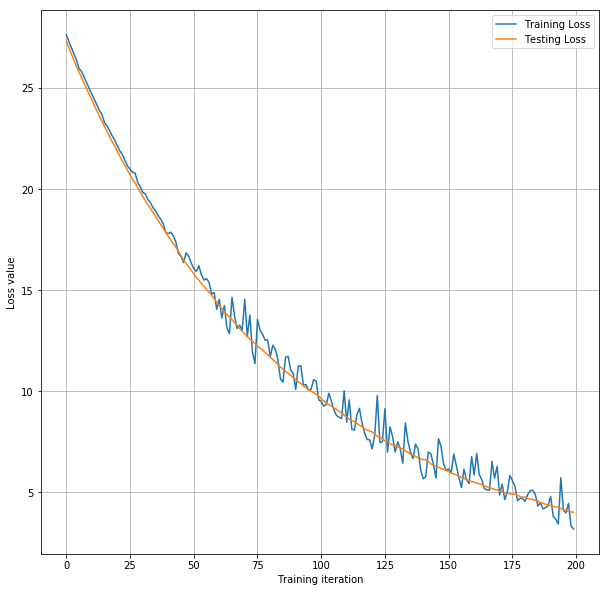

In [8]:
plt.figure(figsize=(10,10))
plt.plot(tr_loss)
plt.plot(te_loss)
plt.grid()
plt.xlabel('Training iteration')
plt.ylabel('Loss value')
plt.legend(['Training Loss','Testing Loss'])

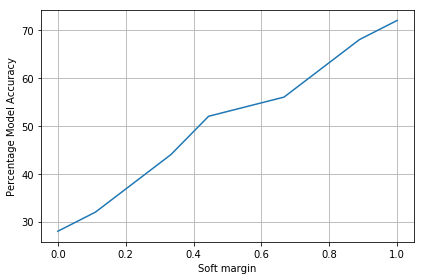

In [9]:
def soft_accuracy(pred,y_test):
    acc = []
    for e in np.linspace(0,1,10):
        acc.append(sum([True for i in range(len(pred))  if pred[i] in [int(y_test[i]),int(y_test[i]+e),int(y_test[i]-e)]]))
    acc = np.array(acc)
    return acc*100.0/len(pred)
pred = []
for i in x_test:
    pred.append(np.argmax(model.predict(np.array([i]))))
#plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,10),soft_accuracy(pred,y_test))
plt.grid()
plt.xlabel('Soft margin')
plt.ylabel('Percentage Model Accuracy')
plt.tight_layout()

Genrating filter map...Done.


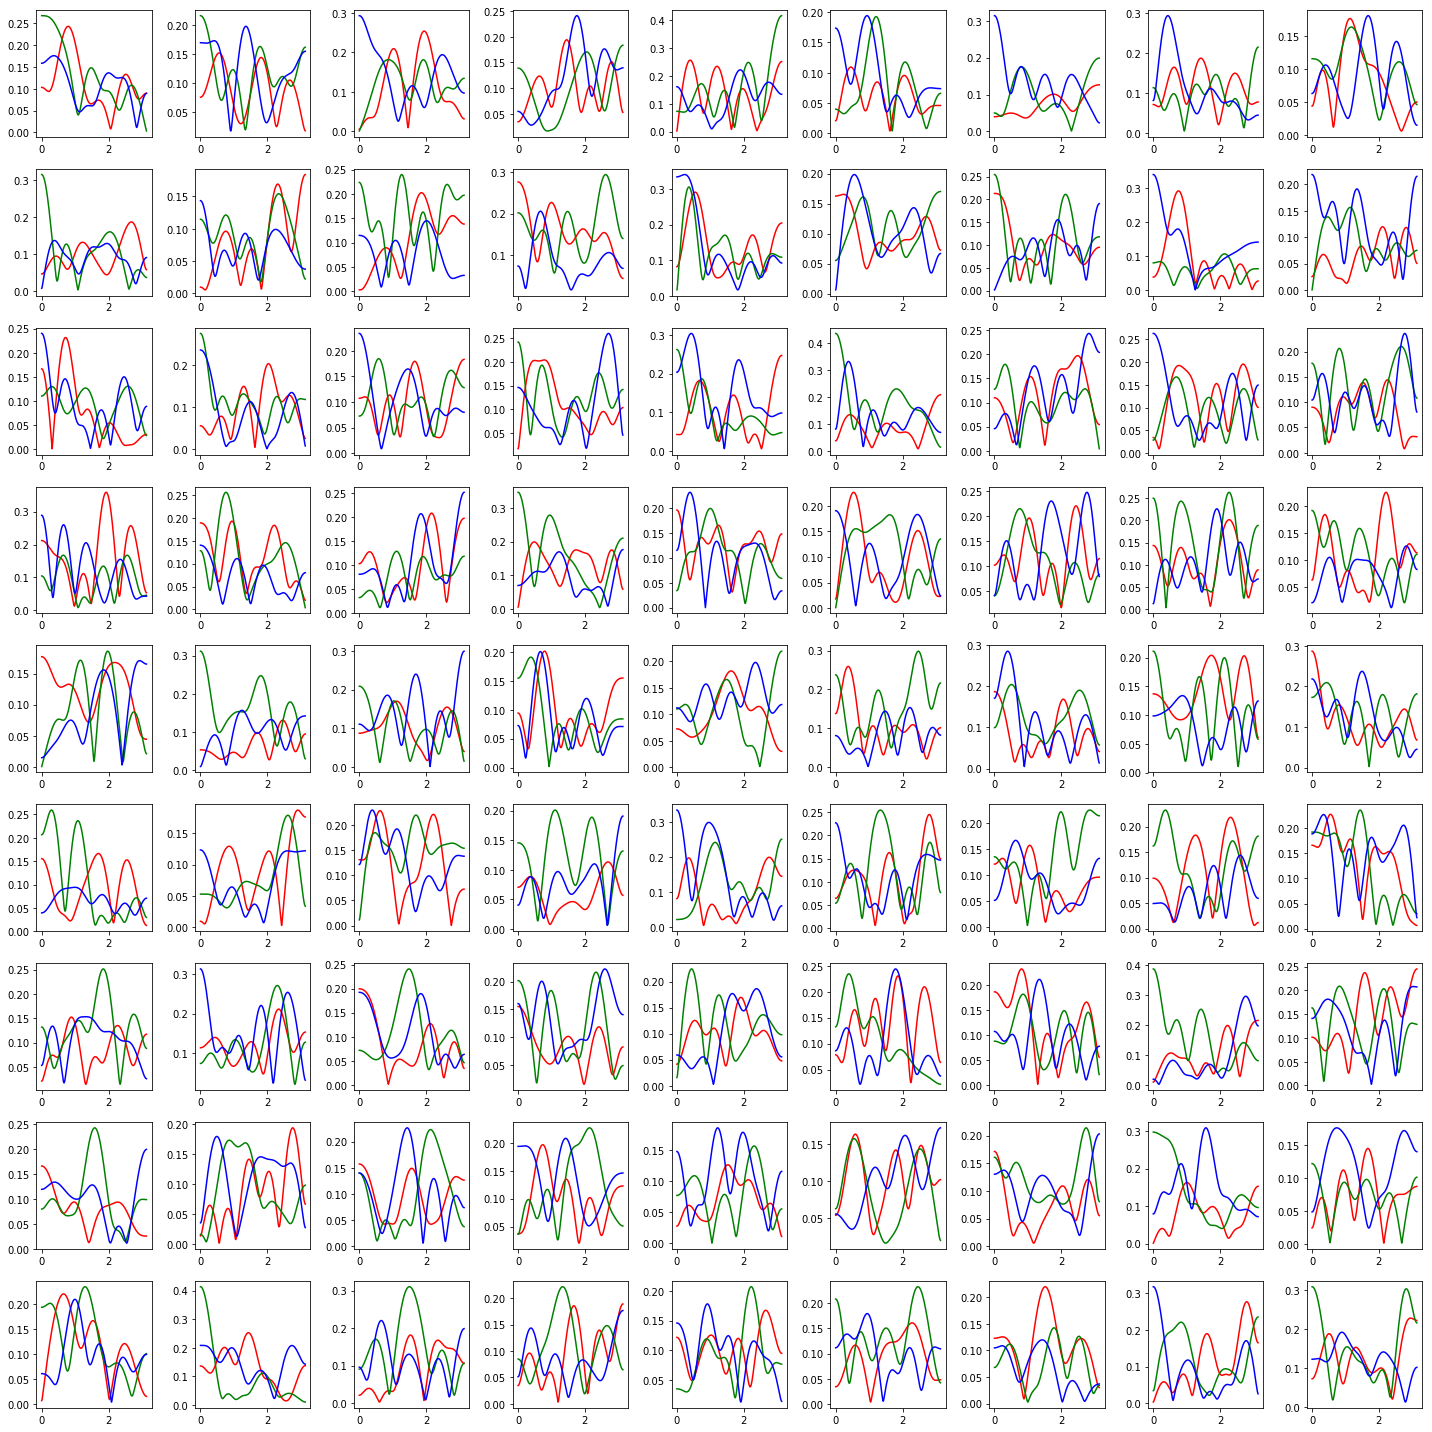

In [11]:
filters = first_layer.get_weights()
print('Genrating filter map...',end='')
plt.figure(figsize=(20,20))
for i in range(9):
    for j in range(9):
        fno=i*9 + j
        tempf1 = []
        tempf1.append(filters[1][fno])
        tempf2 = []
        tempf2.append(filters[1][fno])
        tempf3 = []
        tempf3.append(filters[1][fno])
        for k in range(11):
            tempf1.append(filters[0][k][0][fno])
            tempf2.append(filters[0][k][1][fno])
            tempf3.append(filters[0][k][2][fno])
        w1,h1 = freqz(tempf1)
        w2,h2 = freqz(tempf2)
        w3,h3 = freqz(tempf3)
        plt.subplot(9,9,fno+1)
        plt.plot(w1,np.abs(h1),color='r')
        plt.plot(w2,np.abs(h2),color='g')
        plt.plot(w3,np.abs(h3),color='b')
plt.tight_layout()
plt.savefig('FilterMap.png')
print('Done.')